In [13]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import chess
import chess.pgn

from torch.utils.data import Dataset, DataLoader, IterableDataset

from time import time
import tqdm

HEADERS = ("result", "whiteElo", "blackElo", "timeControl", "sideToPlay", "bitmaps", "movePlayed")
TRAINING_SET_SIZE = 2867018
BATCH_SIZE = 64

In [14]:
def extract_fens_from_pgn(pgn_file, label_from="result"):
    positions = []
    with open(pgn_file, "r", encoding="utf-8") as f:
        while True:
            game = chess.pgn.read_game(f)
            if game is None:
                break

            board = game.board()
            result = game.headers.get("Result")

            # Label based on game outcome
            if result == "1-0":
                label = 1.0
            elif result == "0-1":
                label = -1.0
            else:
                label = 0.0

            # Step through moves
            for move in game.mainline_moves():
                board.push(move)
                fen = board.fen()
                positions.append((fen, label))  # ← You can also call Stockfish here if you want

    return positions


In [15]:
import torch.nn as nn
import torch.nn.functional as F
class PositionEvaluatorNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(13, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        return torch.tanh(self.fc2(x))  # Output between -1 and 1
    

class ChessBotNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # 13 channels: 12 pieces + side to play (tensor[true's|false's])
        self.conv1 = nn.Conv2d(13, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8 * 8 * 128, 256)
        self.fc2 = nn.Linear(256, 64)
        self.relu = nn.ReLU()

        # Initialize weights
        nn.init.kaiming_uniform_(self.conv1.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.conv2.weight, nonlinearity='relu')
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)


    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)  # Output raw logits
        return x
## Idea:
##   One model that answers "best piece to move in this position"
##   Then another model that answers "best square to move piece X to"

In [16]:
piece_to_idx = {
    'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
    'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11
}

def board_to_tensor(board):
    tensor = np.zeros((12, 8, 8), dtype=np.uint8)
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            idx = piece_to_idx[piece.symbol()]
            row = 7 - square // 8
            col = square % 8
            tensor[idx, row, col] = 1
    return tensor

def idxToUci(idx):
    return chr(ord('a') + idx % 8) + str(idx // 8 + 1)

In [17]:
import ast
import csv
from io import StringIO
import json
import random
from typing import Literal
import pandas as pd
import polars as pl

class ChessEvalDataset(Dataset):
# class ChessEvalDataset(IterableDataset):
    def __init__(self, file: str, model: Literal["pieces", "moves"] = "pieces", load_batch_size = 6_400):
        self.model = model
        self.lazy_dataset = pl.scan_csv(file, has_header=False, new_columns=HEADERS)
        self.batch_size = load_batch_size
        self.feature_cols = ["bitmaps", "sideToPlay"]
        self.target_col = "movePlayed"
        self.cached_batches = {}
        self.batches_ids: list[int] = list()
        self.total_rows = self.lazy_dataset.select(pl.len()).collect().item()

    def __len__(self):
        return self.total_rows
    
    def __uciMoveToSquare(self, move: str):
        return (ord(move[0]) - ord('a')) + (int(move[1]) - 1) * 8

    def __getitem__(self, idx):
        # Calculate which batch this index belongs to
            batch_idx = idx // self.batch_size
            
            # Check if this batch is already cached
            if batch_idx not in self.cached_batches:
                # Calculate batch range
                start_idx = batch_idx * self.batch_size
                end_idx = min((batch_idx + 1) * self.batch_size, self.total_rows)
                
                # Fetch only this batch of data using offset and limit
                batch_dataset = (self.lazy_dataset
                            .slice(start_idx, end_idx - start_idx)
                            .collect())
                
                # Process features and target
                features = batch_dataset.select(self.feature_cols)
                bitmaps = np.empty(shape=(end_idx-start_idx, 12, 8, 8))

                bitmaps_list = [json.loads(bmp) for bmp in features["bitmaps"]]
                bitmaps = np.array(bitmaps_list, dtype=np.float32)


                side_channels = np.array([
                    np.ones((1, 8, 8)) if side == "True" else np.zeros((1, 8, 8))
                    for side in features["sideToPlay"]
                ], dtype=np.float32)
    
                bitmaps = np.concatenate((bitmaps, side_channels), axis = 1)
                features = torch.tensor(bitmaps, dtype=torch.float32)
                
                targets = batch_dataset.select(self.target_col).to_numpy()
                target_values = np.empty(shape=(end_idx-start_idx))
                for idx, move in enumerate(targets):
                    move = move[0]
                    if self.model == "pieces":
                        label = move[:2]
                    else:
                        label = move[2:]
                    target_values[idx] = self.__uciMoveToSquare(label)
                    
                targets = torch.tensor(target_values, dtype=torch.long)
                
                # Cache this batch
                self.cached_batches[batch_idx] = (features, targets)
                
                if len(self.cached_batches) > 1:  # Keep only 1 batches in memory, delete oldest
                    self.cached_batches.pop(self.batches_ids[0])
                    self.batches_ids.pop(0)
                self.batches_ids.append(batch_idx)

            
            # Get the item from the cached batch
            features, targets = self.cached_batches[batch_idx]
            idx_in_batch = idx % self.batch_size
            
            return features[idx_in_batch], targets[idx_in_batch]

    # def parse_line(self, line: str):
    #     parts = next(
    #         csv.DictReader(StringIO(line), quoting=csv.QUOTE_MINIMAL, fieldnames=HEADERS)
    #     )
        
    #     entry = {
    #         "bitmaps": ast.literal_eval(parts["bitmaps"]),
    #         "sideToPlay": parts["sideToPlay"] == "True",
    #         "movePlayed": parts["movePlayed"]
    #     }

    #     bitmaps = np.array(entry["bitmaps"])
    #     side_channel = np.ones((1, 8, 8)) if entry["sideToPlay"] else np.zeros((1, 8, 8))

    #     bitmaps = np.concatenate((bitmaps, side_channel))
    #     X = torch.tensor(bitmaps, dtype=torch.float32)

    #     move = entry["movePlayed"]
    #     if self.model == "pieces":
    #         label = move[:2]
    #     else:
    #         label = move[2:]
    #     y = torch.tensor(self.__uciMoveToSquare(label)).long()
    #     print(X)
    #     print(y)
    #     return X, y
    
    # def __iter__(self):
    #     READ_SIZE = 16_384 # 4.5GiB in GPU
    #     with open(self.file, "r") as f:
    #         for idx in range(TRAINING_SET_SIZE):
    #             lines = f.readlines(READ_SIZE)
    #             X_batch = torch.empty(READ_SIZE, 13, 8, 8)
    #             y_batch = torch.empty(READ_SIZE, 64, 1)
    #             for idx, line in enumerate(lines):
    #                 # self.open_file.seek(self.offsets[idx]) # Go to line idx
    #                 # yield self.parse_line(self.open_file.readline())
    #                 X, y = self.parse_line(line)
    #                 X_batch[idx] = X
    #                 y_batch[idx] = y
    #             yield X_batch, y_batch

In [ ]:
DATASET_PATH = '../dataset/processed/results_skip_initial.csv'
NUM_EPOCHS = 100

TRAINING_MODE = "pieces" # "pieces" or "moves"
MODEL_WEIGHTS_OUTPUT_PATH = "pieces_model_v2_SKIP_COMPLETE.pth"
test = ChessEvalDataset(file = DATASET_PATH, model=TRAINING_MODE, load_batch_size = 300_000)
loader = DataLoader(test, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ChessBotNetwork().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

print(torch.cuda.is_available())
print("Using device: ", device)
for epoch in range(NUM_EPOCHS):
    model.train()
    t0 = time()
    running_loss = 0.0
    for board_tensor_batch, target_eval_batch in tqdm.tqdm(loader):
        # # Load data to GPU
        # board_tensor_batch, target_eval_batch = board_tensor_batch.to(device), target_eval_batch.to(device)

        # # Clear gradients
        # optimizer.zero_grad()
        
        # # predict
        # pred = model(board_tensor_batch)

        # # Calculate loss
        # loss = loss_fn(pred, target_eval_batch)
        # loss.backward()

        # optimizer.step()
        board_tensor_batch, target_eval_batch = board_tensor_batch.to(device), target_eval_batch.to(device)  # Move data to GPU
        optimizer.zero_grad()

        outputs = model(board_tensor_batch)  # Raw logits

        # Compute loss
        loss = loss_fn(outputs, target_eval_batch)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        running_loss += loss.item()
    tf = time()
    print(f"Epoch {epoch}, Loss: {loss.item():.4f} - {running_loss / len(loader):.4f} | Time: {tf-t0}")

    if epoch % 5 == 0:
        torch.save(model.state_dict(), f"pieces_model_v2_SKIP_COMPLETE_epoch_{epoch+1}.pth")       
# Save the trained model
torch.save(model.state_dict(), MODEL_WEIGHTS_OUTPUT_PATH)

True
Using device:  cuda


100%|██████████| 44798/44798 [09:11<00:00, 81.19it/s]  


Epoch 0, Loss: 3.5458 - 2.8151 | Time: 551.7901456356049


100%|██████████| 44798/44798 [09:10<00:00, 81.38it/s]  


Epoch 1, Loss: 2.9989 - 2.6375 | Time: 550.5076780319214


100%|██████████| 44798/44798 [09:12<00:00, 81.10it/s]  


Epoch 2, Loss: 2.8198 - 2.5813 | Time: 552.4139201641083


100%|██████████| 44798/44798 [09:08<00:00, 81.68it/s]  


Epoch 3, Loss: 2.6120 - 2.5501 | Time: 548.4742512702942


100%|██████████| 44798/44798 [09:11<00:00, 81.19it/s]  


Epoch 4, Loss: 2.5908 - 2.5294 | Time: 551.7676954269409


100%|██████████| 44798/44798 [09:11<00:00, 81.16it/s]  


Epoch 5, Loss: 2.4443 - 2.5151 | Time: 551.953362941742


100%|██████████| 44798/44798 [09:12<00:00, 81.02it/s]  


Epoch 6, Loss: 2.4662 - 2.5045 | Time: 552.9496583938599


100%|██████████| 44798/44798 [09:11<00:00, 81.26it/s]  


Epoch 7, Loss: 2.4281 - 2.4973 | Time: 551.3337068557739


100%|██████████| 44798/44798 [09:15<00:00, 80.65it/s]  


Epoch 8, Loss: 2.5981 - 2.4913 | Time: 555.4715375900269


100%|██████████| 44798/44798 [09:14<00:00, 80.86it/s]  


Epoch 9, Loss: 2.4316 - 2.4869 | Time: 554.0221173763275


100%|██████████| 44798/44798 [09:13<00:00, 80.94it/s]  


Epoch 10, Loss: 2.4665 - 2.4834 | Time: 553.4593617916107


100%|██████████| 44798/44798 [09:17<00:00, 80.39it/s]  


Epoch 11, Loss: 2.5155 - 2.4803 | Time: 557.2920262813568


100%|██████████| 44798/44798 [09:13<00:00, 80.88it/s]  


Epoch 12, Loss: 2.4834 - 2.4777 | Time: 553.9028615951538


100%|██████████| 44798/44798 [09:18<00:00, 80.26it/s]  


Epoch 13, Loss: 2.2772 - 2.4755 | Time: 558.1461434364319


100%|██████████| 44798/44798 [09:11<00:00, 81.24it/s]  


Epoch 14, Loss: 2.4089 - 2.4738 | Time: 551.4092671871185


100%|██████████| 44798/44798 [09:19<00:00, 80.08it/s]  


Epoch 15, Loss: 2.3967 - 2.4726 | Time: 559.4352178573608


100%|██████████| 44798/44798 [09:18<00:00, 80.19it/s]  


Epoch 16, Loss: 2.2989 - 2.4714 | Time: 558.6377696990967


100%|██████████| 44798/44798 [09:19<00:00, 80.10it/s]  


Epoch 17, Loss: 2.3548 - 2.4701 | Time: 559.2723956108093


100%|██████████| 44798/44798 [09:19<00:00, 80.05it/s]  


Epoch 18, Loss: 2.3393 - 2.4696 | Time: 559.6375710964203


100%|██████████| 44798/44798 [09:23<00:00, 79.48it/s]  


Epoch 19, Loss: 2.3741 - 2.4685 | Time: 563.6495125293732


100%|██████████| 44798/44798 [09:18<00:00, 80.15it/s]  


Epoch 20, Loss: 2.2033 - 2.4677 | Time: 558.9563934803009


 31%|███▏      | 14050/44798 [03:07<01:10, 434.41it/s]

In [ ]:
# import csv
# from io import StringIO
# import pandas as pd
# import numpy as np
# import ast
# torch.save(model.state_dict(), "pieces_model_skip_initial_full_dataset.pth")
# test = pd.read_csv(
#     '../dataset/processed/results_skip_initial.csv', 
#     nrows = 20, 
#     names = HEADERS,
# )
# entry = test.iloc[0]
# bitmaps = np.array(ast.literal_eval(entry["bitmaps"]))
# side_channel = np.ones((1, 8, 8)) if entry["sideToPlay"] == "True" else np.zeros((1, 8, 8))

# bitmaps = np.concatenate((bitmaps, side_channel), axis=0)
# X = bitmaps
# played_move = entry["movePlayed"]
import pandas as pd
from time import time
DATASET_PATH = '../dataset/processed/results_skip_initial.csv'
t0 = time()
df = pd.read_csv(DATASET_PATH, names=HEADERS, nrows=50_000)
print(f"PANDAS: Took {time() - t0} seconds to read the dataset")


import polars as pl
lazy_dataset = pl.scan_csv(DATASET_PATH, has_header=False, new_columns=HEADERS)
t0 = time()
batch_dataset = (lazy_dataset
            .slice(0, 50_000)
            .collect())
features = batch_dataset.select(["bitmaps", "sideToPlay", "movePlayed"])
print(f"POLAR: Took {time() - t0} seconds to read the dataset")
# PANDAS: Took 0.6252572536468506 seconds to read the dataset
# POLAR: Took 0.07185816764831543 seconds to read the dataset

PANDAS: Took 0.6680021286010742 seconds to read the dataset
POLAR: Took 0.07720422744750977 seconds to read the dataset


In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
trained_model = ChessBotNetwork().to(device)
trained_model.load_state_dict(torch.load("./pieces_model_skip_initial_full_dataset.pth"))
trained_model.eval()  # Set model to evaluation mode

def predict_move(bitmaps):
    X_tensor = torch.tensor(bitmaps, dtype=torch.float32).cuda().to(device)
    
    with torch.no_grad():
        logits = trained_model(X_tensor)
    
    logits = logits.squeeze(0)  # Remove batch dimension
    
    probabilities = torch.softmax(logits, dim=0).cpu().numpy()  # Convert to probabilities
    
    return probabilities

RuntimeError: PytorchStreamReader failed locating file data/0: file not found

In [ ]:
# import matplotlib.pyplot as plt
# import chess

# def plot_board(bitmaps, move_probs=None):
#     board = np.zeros((8,8,3))
#     colors = [(240/255, 217/255, 181/255), (181/255, 136/255, 99/255)]

#     fig, ax = plt.subplots(figsize=(8, 8))
#     for i in range(8):
#         for j in range(8):
#             color = colors[(i + j) % 2]
#             rect = plt.Rectangle((j, 7-i), 1, 1, facecolor=color)
#             ax.add_patch(rect)
#             piece_symbols = ['P', 'N', 'B', 'R', 'Q', 'K', 'p', 'n', 'b', 'r', 'q', 'k']

#     for idx, symbol in enumerate(piece_symbols):
#         channel = bitmaps[idx]
#         for i in range(8):
#             for j in range(8):
#                 if channel[i, j] == 1:
#                     ax.text(j + 0.5, 7-i + 0.5, symbol, fontsize=24, ha='center', va='center')

#     if move_probs is not None:
#         for i in range(8):
#             for j in range(8):
#                 prob = move_probs[i, j]
#                 if prob > 0.05: 
#                     ax.text(j + 0.5, 7-i + 0.8, f"{prob:.2f}", fontsize=8, color="red", ha='center')

#     ax.set_xlim(0, 8)
#     ax.set_ylim(0, 8)
#     ax.set_xticks([])
#     ax.set_yticks([])
#     plt.show()


########## WORKING CODDE:
# import matplotlib.pyplot as plt
# import numpy as np

# # Mapping of piece letters to unicode chess symbols
# PIECE_UNICODE = {
#     'P': '♙', 'N': '♘', 'B': '♗', 'R': '♖', 'Q': '♕', 'K': '♔',
#     'p': '♟︎', 'n': '♞', 'b': '♝', 'r': '♜', 'q': '♛', 'k': '♚'
# }

# def plot_board(bitmaps, move_probs=None):
#     board = np.zeros((8, 8, 3))
#     colors = [(240/255, 217/255, 181/255), (181/255, 136/255, 99/255)]

#     fig, ax = plt.subplots(figsize=(8, 8))

#     # Draw squares
#     for i in range(8):
#         for j in range(8):
#             color = colors[(i + j) % 2]
#             rect = plt.Rectangle((j, 7-i), 1, 1, facecolor=color)
#             ax.add_patch(rect)

#     # Draw pieces
#     piece_symbols = [ 'P', 'N', 'B', 'R', 'Q', 'K', 'p', 'n', 'b', 'r', 'q', 'k']
#     for idx, symbol in enumerate(piece_symbols):
#         channel = bitmaps[idx]
#         for i in range(8):
#             for j in range(8):
#                 if channel[i, j] == 1:
#                     piece_unicode = PIECE_UNICODE[symbol]
#                     ax.text(j + 0.5, 7 - i + 0.5, piece_unicode, fontsize=48, ha='center', va='center')

#     # Draw move probabilities
#     if move_probs is not None:
#         for i in range(8):
#             for j in range(8):
#                 prob = move_probs[i, j]
#                 if prob > 0:  # Show only significant probs
#                     ax.text(j + 0.5, 7 - i + 0.1, f"{prob:.2f}", fontsize=8, color="red", ha='center')
#                     # ax.text(j + 0.5, i + 0.8, f"{i*8 + j}", fontsize=8, color="red", ha='center')

#     # Add a-h and 1-8 labels
#     # files = ['h', 'g', 'f', 'e', 'd', 'c', 'b', 'a']
#     files = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
#     ranks = ['8', '7', '6', '5', '4', '3', '2', '1']
#     for i in range(8):
#         # Bottom labels
#         ax.text(i + 0.5, -0.3, files[i], ha='center', va='center', fontsize=14)
#         # Left side labels
#         ax.text(-0.3, i + 0.5, ranks[7-i], ha='center', va='center', fontsize=14)

#     ax.set_xlim(0, 8)
#     ax.set_ylim(0, 8)
#     ax.set_xticks([])
#     ax.set_yticks([])
#     plt.gca().set_aspect('equal', adjustable='box')
#     plt.show()


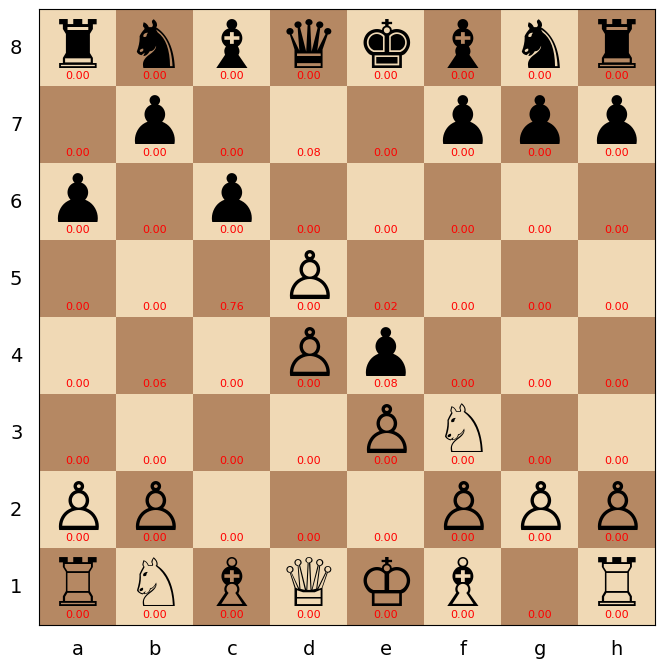

array([4.6589840e-03, 8.3108813e-02, 7.6623895e-04, 7.5574476e-01,
       7.6813303e-02, 2.0228499e-06, 5.6386908e-04, 8.0368619e-07],
      dtype=float32)

In [ ]:
# y = predict_move(bitmaps)  # model output
# y2 = np.reshape(y, (8, 8)) # reshape to 8x8
# plot_board(bitmaps, move_probs=y2)
# np.max(y2, axis=1)

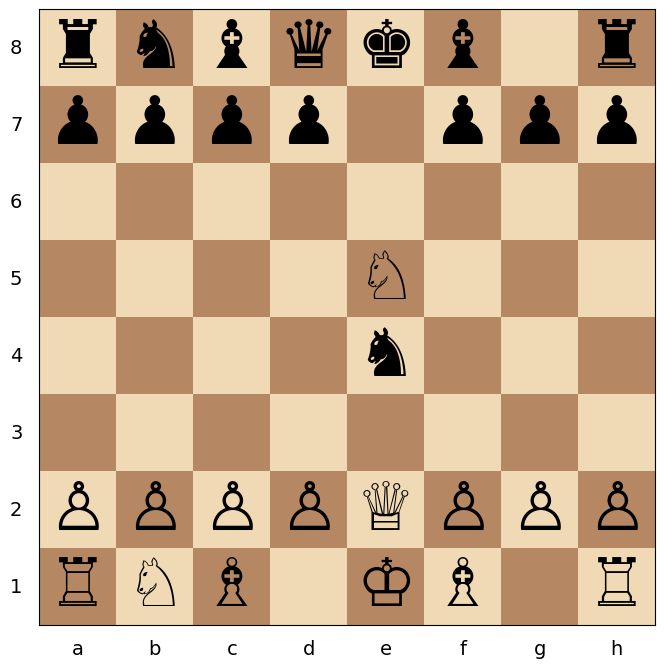

In [ ]:
# board = chess.Board()
# probs = np.zeros((8, 8))
# input_tensor = board_to_tensor(board)

# while not board.is_game_over():
#     plot_board(input_tensor, move_probs=np.reshape(probs, (8,8)))

#     user_move = input("Your move (e.g., e2e4): ")
#     if user_move == "exit":
#         break
#     try:
#         board.push_san(user_move)
#     except Exception as e:
#         print("Invalid move. Try again.")
#         continue

#     # Convert board to bitmap
#     bitmaps = board_to_tensor(board)
#     side_channel = np.ones((1, 8, 8)) if board.turn == chess.WHITE else np.zeros((1, 8, 8))
#     input_tensor = np.concatenate((bitmaps, side_channel), axis=0)

#     # Model predicts best move
#     probs = predict_move(input_tensor)
#     best_square_idx = np.argmax(probs, keepdims=True)
    
#     # Here you can pick any legal move from that square (some logic needed)
#     # For now, let's print it
#     print(f"Model suggests moving from square index {idxToUci(int(best_square_idx))}") # Doesnt work idxToUci
